# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
import time
import pickle
import numpy as np
import tensorflow as tf
import csv
import cv2
from cv2 import createCLAHE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.optimizers import Adam, SGD
from keras.layers import Input, Flatten, Dense, Conv2D, Add, Lambda, Cropping2D, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout, Concatenate
from keras.models import Model

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

DISABLE_PRINTS = False
EVALUATE_BATCH_TRAINING = False
GENERATE_AUGMENTED_DATA = False
USE_AUGMENTED = False
ADAPT_LEARNING_RATE = False
TRAIN_MODEL = True
GRAY_SCALE = True 
LEARNING_CURVE = False # If False trains for all the training set


if GENERATE_AUGMENTED_DATA:
    USE_AUGMENTED = False
    
# Load pickled data
if USE_AUGMENTED:
    training_file = './traffic-signs-data/train_augmented.p'
else:
    training_file = './traffic-signs-data/train.p'

validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

train_dict = pickle.load(open(training_file, mode='rb') )
valid_dict = pickle.load(open(validation_file, mode='rb'))
test_dict  = pickle.load(open(testing_file, mode='rb'))

if USE_AUGMENTED:
    X_train, y_train = train_dict['features'], train_dict['labels']
else:
    coords_train, X_train, sizes_train, y_train = train_dict['coords'], train_dict['features'], train_dict['sizes'], train_dict['labels']

X_valid, y_valid = valid_dict['features'], valid_dict['labels']
X_test, y_test = test_dict['features'], test_dict['labels']

Using TensorFlow backend.


In [2]:
def histogram_equalization(data_set, equalize = True, gridSize = (4, 4)):
    '''
    1) computes variance of pixel values in a gray scale image
    2) equalizes the grayscale image using CLAHE for better contrast   
    
    '''
    perImage_pixel_variance = []
    hist_equ_data_set = []
    clahe = createCLAHE(tileGridSize=gridSize)
    for img in data_set:        
        
        if img.shape[-1] == 3: 
            img_YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)            
            y_channel = img_YCrCb[...,0]
            # Compute the variance of grayscale image b4 equalization
            perImage_pixel_variance.append(np.var(y_channel))
            if equalize:                
                y_channel = clahe.apply(y_channel)            
                img_YCrCb[..., 0] = y_channel
                img_rgb = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
                hist_equ_data_set.append(img_rgb)              
        else:
            gray_scale_img = np.copy(img)        
            # Compute the variance of grayscale image b4 equalization
            perImage_pixel_variance.append(np.var(gray_scale_img))
            if equalize:
                gray_scale_img = clahe.apply(gray_scale_img)            
                hist_equ_data_set.append(gray_scale_img)  
            
    
    if equalize:
        if data_set.shape[-1] == 3:
            return np.array(hist_equ_data_set)
        else:
            return np.expand_dims(hist_equ_data_set, axis = 3)
    else:
        return np.array(perImage_pixel_variance)
    

def get_boxed_images(data_set, coords, sizes):    
    '''
    Draw bounding boxes on images
    '''
    boxed_data = []
    for idx in range(data_set.shape[0]):
        img = data_set[idx]
        x1, y1, x2, y2 = coords[idx,:]
        x1 = round(x1*32/sizes[idx,0]).astype('int')
        x2 = round(x2*32/sizes[idx,0]).astype('int')
        y1 = round(y1*32/sizes[idx,1]).astype('int')
        x2 = round(y2*32/sizes[idx,1]).astype('int')
        bbox = [(x1, y1), (x2, y2)]
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 1)
        boxed_data.append(img)
    
    return np.array(boxed_data)


def get_cropped_images(data_set, coords, sizes):    
    '''
    Crop images using bounding boxes
    '''
    cropped_data = []
    for idx in range(data_set.shape[0]):
        img = data_set[idx]
        x1, y1, x2, y2 = coords[idx,:]
        x1 = round(x1*32/sizes[idx,0]).astype('int')
        x2 = round(x2*32/sizes[idx,0]).astype('int')
        y1 = round(y1*32/sizes[idx,1]).astype('int')
        x2 = round(y2*32/sizes[idx,1]).astype('int')
        cropped_data.append(cv2.resize(img[y1:y2+1,x1:x2+1], (32, 32)))
    
    return np.array(cropped_data)


def normalize_dataset(data_set):
    '''
    normalizes image such that for each image pixel values are between -0.5, +0.5
    '''
    normalized_data_set = []
    for s in range(data_set.shape[0]):
        img  = np.copy(data_set[s]).astype(float)
        max_pixel = np.max(img)
        min_pixel = np.min(img)
        # pixels after normalization are in range [-0.5, +0.5]
        img = (img - min_pixel)/(max_pixel-min_pixel) - 0.5
        normalized_data_set.append(img)    
    
    return np.array(normalized_data_set)

def gray_scale_dataset(data_set):
    if data_set.shape[-1] == 3:
        ''' converts RGB images to gray scale'''
        return np.expand_dims([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in data_set], axis = 3)
    else:
        return np.array(data_set)

def show_image(img):
    '''
    Helper function for display.
    Converts an image into uint8
    '''
    if np.min(img) < 0:
        # convert all pixels positive for display purposes
        img = img + np.absolute(np.min(img))
    img = img/np.max(img)*255
    img = img.astype('uint8')
    return img 



def list_images(images, xaxis = "", yaxis ="", cmap=None, ncols = 10, title = ''):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            yaxis (Default = " "): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(10, 10))    
    n_images = len(images)
    nrows = np.ceil(n_images/ncols) 

    for i in range(n_images):
        plt.subplot(nrows, ncols, i+1)
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if images[i].shape[-1] != 3 else cmap
        plt.imshow(np.squeeze(show_image(images[i])), cmap = cmap)
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.xticks([])
        plt.yticks([])    
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)    
    plt.title(title, loc = 'center', fontsize=16)        
    plt.show()        
    
    
def rotate_image(image, angle_range = (5, 15)):
    """Source:
    http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations
    /py_geometric_transformations.html
    """
    random_angle = np.random.uniform(angle_range[0], angle_range[1], size = 1)*(np.random.randint(2, size=1)*2-1)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, random_angle, scale = 1)
    return(cv2.warpAffine(image, rot_mat, image.shape[1::-1]))

def rotate_dataset(data_set):
    if data_set.shape[-1] == 3:
        ndim = 3
    else:
        ndim = 1
        
    """This function rotates each image in the data set around its center"""
    return np.array([rotate_image(img) for img in data_set]).reshape(data_set.shape[0], 32,32,ndim)

def augment_brightness_images(image):    
    img_YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)            
    random_bright = np.random.uniform(0.75, 1.25)
    img_YCrCb[:,:,0] *= random_bright
    img_rgb = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
    return image1

def augment_brightness_dataset(data_set):
    if data_set.shape[-1] == 3:
        ndim = 3
    else:
        ndim = 1    
    return np.array([augment_brightness_images(img) for img in data_set]).reshape(data_set.shape[0], 32,32,ndim)


def motion_blur_dataset(data_set):
    """
    Source: https://www.packtpub.com/mapt/book/application_development/9781785283932/2/ch02lvl1sec21/motion-blur
    Blurs an image to represent image captured while in motion
    Args:
        image
    Returns:
        image
    """    
    size = 3
    # generating the kernel
    kernel_motion_blur = np.zeros((size, size))
    kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
    kernel_motion_blur = kernel_motion_blur / size

    if data_set.shape[-1] == 3:
        ndim = 3
    else:
        ndim = 1
    

    # applying the kernel to the input image
    return np.array([cv2.filter2D(img, -1, kernel_motion_blur) for img in data_set]).reshape(data_set.shape[0], 32,32,ndim)

def augment_data(X_train, y_train):
    """
    Create data augmented with 
    1. each image is rotated randomly by -15<angle<-5 or 5<angle<15 and scaled by 0.9 or 1.1
    2. Motion blurred by a kernel of size 4
    X_rotate       = rotate_dataset(X_train)
    X_motion_blur  = motion_blur_dataset(X_train)        
    X_train        = np.concatenate((X_train, X_rotate, X_motion_blur), axis = 0)
    y_train        = np.concatenate((y_train, y_train, y_train))
    """
    X_rotate       = rotate_dataset(X_train)
    X_brightness  = augment_brightness_dataset(X_train)        
    X_train        = np.concatenate((X_train, X_rotate, X_brightness), axis = 0)
    y_train        = np.concatenate((y_train, y_train, y_train))
    
    return  {'features': X_train, 'labels': y_train}

def preprocess_data(data_dict, normalize = True, crop = False, gray = False, histEqual = False):
    data_set = data_dict["features"]
    if gray:
        data_set = gray_scale_dataset(data_set)

    if crop:
        data_set = get_cropped_images(data_set, data_dict["coords"], data_dict["sizes"] )

    if histEqual:        
        data_set = histogram_equalization(data_set)

    if normalize:
        data_set = normalize_dataset(data_set)

    return np.array(data_set)



In [3]:
def evaluate(X_data, y_data):
    # ********************** hyper-parameters ************************
    batch_size  = 1024 # non consequential parameter for eval
    # ********************** **********************************************
    
    num_examples    = X_data.shape[0]
    totalAccuracy   = 0
    totalLoss       = 0

    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        batch_accuracy, batch_loss = sess.run([accuracy_operation, loss_operation], 
                                              feed_dict={x: batch_x, 
                                                           y: batch_y, 
                                                           BN: False, 
                                                           keep_prob_fc: np.ones(2).reshape([2, 1]),
                                                           beta_regularization: np.zeros(2).reshape([2, 1])})
        totalAccuracy   += (batch_accuracy * batch_x.shape[0])
        totalLoss       += (batch_loss * batch_x.shape[0])

    return {"loss": totalLoss/num_examples, "accuracy": totalAccuracy/num_examples}


def train_model(X_train, y_train, X_valid, y_valid, hyperPar_dict):    
    # ********************** read hyper-parameters ************************
    epochs              = hyperPar_dict['epochs']
    batch_size          = hyperPar_dict['batch_size']
    learning_rate       = hyperPar_dict['learning_rate']
    batch_norm          = hyperPar_dict['batch_norm']
    keep_probability_fc = hyperPar_dict['keep_prob_fc']
    beta_regularization_parameters = hyperPar_dict['beta_regularization']
    # ********************** ********************* ************************
    
    training_loss       = np.zeros(epochs)
    training_accuracy   = np.zeros(epochs)
    validation_loss     = np.zeros(epochs)
    validation_accuracy = np.zeros(epochs)
    
    with tf.Session() as sess:               
        sess.run(tf.global_variables_initializer())                
        for i in range(epochs): 
            t1 = time.time()
            if (i+1)%20 == 0 and ADAPT_LEARNING_RATE:
                learning_rate *= 0.3
            
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, X_train.shape[0], batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, 
                                                        y: batch_y, 
                                                        BN: batch_norm, 
                                                        learn_rate: learning_rate,
                                                        keep_prob_fc: keep_probability_fc,
                                                        beta_regularization: beta_regularization_parameters})

            t2 = time.time()            
            # **************** update results after an epoch ************************
            if EVALUATE_BATCH_TRAINING:
                training_results_dict   = evaluate(batch_x, batch_y)
            else:
                training_results_dict   = evaluate(X_train, y_train)

            validation_results_dict = evaluate(X_valid, y_valid)
            t3 = time.time()

            training_accuracy[i]    = training_results_dict['accuracy']
            training_loss[i]        = training_results_dict['loss']        
            validation_accuracy[i]  = validation_results_dict['accuracy']
            validation_loss[i]      = validation_results_dict['loss']        
            # *********************************************************************** 
            if not DISABLE_PRINTS:            
                print("EPOCH {} ...".format(i+1))
                print("Time taken = {:.2f}, {:.2f} ".format((t2-t1), (t3-t2)))
                print("Learning rate = {:.3f}".format(learning_rate*1000))
                print("Training Accuracy = {:.3f}".format(training_accuracy[i]))
                print("Training Loss = {:.3f}".format(training_loss[i]))
                print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
                print("Validation Loss = {:.3f}".format(validation_loss[i]))
                print()
            
        saver.save(sess, './OptimizedModel')
            
    
    results_dict = {"training_accuracy": training_accuracy,
        "validation_accuracy": validation_accuracy,
        "training_loss": training_loss,
        "validation_loss": validation_loss}
    return results_dict



def learning_curve(X_train, y_train, X_valid, y_valid, hyperPar_dict, step_size = 2048):
    training_accuracy_list      = []
    training_loss_list          = []
    validation_accuracy_list    = []    
    validation_loss_list        = []
    
    step_size = np.minimum(step_size, X_train.shape[0])
    
    
    for m_train in range(step_size, X_train.shape[0]+1, step_size):            
        m_valid = int(np.minimum(np.round(m_train*.15), X_valid.shape[0]))
        print("Training using {training_samples} training samples and {valid_samples} validation samples"
              .format(training_samples = m_train, valid_samples = m_valid))
        print()

        X_train, y_train = shuffle(X_train, y_train)
        X_valid, y_valid = shuffle(X_valid, y_valid)        
        #*******************************************
        # Train the model for m samples
        # ******************************************
        results_dict_mSamples = train_model(X_train[0:m_train], y_train[0:m_train],
        X_valid[0:m_valid], y_valid[0:m_valid], 
        hyperPar_dict)            

        training_accuracy_list.append(results_dict_mSamples['training_accuracy'])
        training_loss_list.append(results_dict_mSamples['training_loss'])

        validation_accuracy_list.append(results_dict_mSamples['validation_accuracy'])
        validation_loss_list.append(results_dict_mSamples['validation_loss'])
        

    learning_curve_results = {
        "training_accuracy": np.array(training_accuracy_list),
        "training_loss": np.array(training_loss_list),
        "validation_accuracy": np.array(validation_accuracy_list),
        "validation_loss": np.array(validation_loss_list)
    }   
    

    return learning_curve_results


def display_stats(X_train, y_train, X_valid, y_valid):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_valid = X_valid.shape[0]

    # Number of testing examples.
    n_test = X_test.shape[0]

    # shape of an traffic sign image
    image_shape = np.array([X_train.shape[1], X_train.shape[2]])

    # How many unique classes/labels there are in the dataset.
    N_CLASSES = len(np.unique(y_train))

    # bin count of different classes
    n_train_images_in_a_Class = np.bincount(y_train)

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_valid)
    print("Number of testing examples =", n_test)
    print("Image data shape =", image_shape)
    print("Number of classes =", N_CLASSES)

    # Mapping ClassID to traffic sign names
    signs = []
    signnames = csv.reader(open('signnames.csv', 'r'), delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    

def display_samples(X_data, coords = None, sizes = None):
    # Display sample images
    disp_sample_idx  = np.random.randint(0, X_data.shape[0], 10)

    print(disp_sample_idx)
    
    # display original samples
    print('original images')
    list_images(X_data[disp_sample_idx])

    if not USE_AUGMENTED:
        print('boxed original images')
        list_images(get_boxed_images(data_set   = X_data[disp_sample_idx], coords = coords[disp_sample_idx], sizes = sizes[disp_sample_idx]))
        print('Cropped images')
        list_images(get_cropped_images(data_set = X_data[disp_sample_idx], coords = coords[disp_sample_idx], sizes = sizes[disp_sample_idx]))

    # display normalized samples
    print('normalized images')
    list_images(normalize_dataset(X_data[disp_sample_idx]))

    print('histogram equalized gray scale images')
    list_images(histogram_equalization(X_data[disp_sample_idx]))



def explore_data(X_train, y_train, X_valid, y_valid):
    # explore data set for random 1000 images
    sample_id  = np.random.randint(0, X_train.shape[0], 1000)
    # Mean and variance image of a data set
    X_explore_data = X_train[sample_id]

    mean_img = np.mean(X_explore_data, axis = 0).astype('uint8')
    std_img = np.std(X_explore_data, axis = 0).astype('uint8')
    list_images([mean_img, std_img])
    # Compute histogram of entropy
    # pixel_variance(data_set, equalize = False)
    variance_data = histogram_equalization(X_explore_data, equalize = False)
    plt.hist(variance_data)
    plt.show()

    # Histogram of train
    hist_y_train = np.bincount(y_train)
    hist_y_valid = np.bincount(y_valid)

    nhist_y_train = hist_y_train
    nhist_y_valid = hist_y_valid

    y_pos = np.arange(len(np.unique(y_train)))
    fig, ax = plt.subplots()
    ax.bar(y_pos, nhist_y_train, 0.35, align='center', alpha=0.5, color = 'b', label = 'train')
    #ax.bar(y_pos, nhist_y_valid, 0.8, align='center', alpha=0.5, color = 'g', label = 'valid')
    ax.set_ylabel('count of images in a class')
    ax.set_xlabel('class ID')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.show() 

    fig, ax = plt.subplots()
    #ax.bar(y_pos, nhist_y_train, 0.35, align='center', alpha=0.5, color = 'b', label = 'train')
    ax.bar(y_pos, nhist_y_valid, 0.8, align='center', alpha=0.5, color = 'g', label = 'valid')
    ax.set_ylabel('count of images in a class')
    ax.set_xlabel('class ID')
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
    plt.show() 

    print("Distribution of different classes in training is \n", (hist_y_train))     




---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

----

## Step 2: Design and Test a Model Architecture

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

[23346 28316 20079 33557 12071  1479  7784 33039 20965 12355]
original images


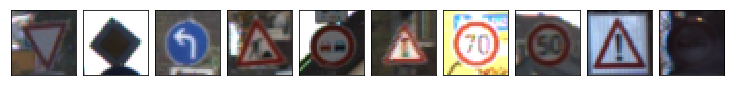

boxed original images


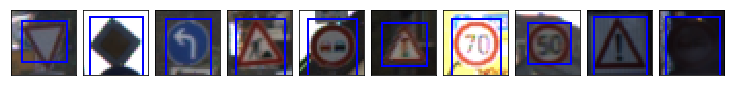

Cropped images


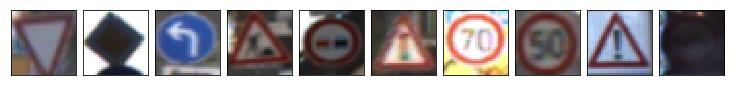

normalized images


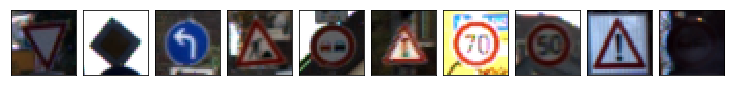

histogram equalized gray scale images


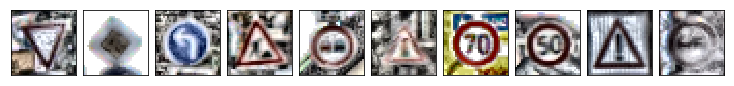

In [4]:
if GENERATE_AUGMENTED_DATA:
    pickle.dump(augment_data(X_train, y_train), open( './traffic-signs-data/train_augmented.p', "wb" ), protocol= pickle.HIGHEST_PROTOCOL)
    

if USE_AUGMENTED:
    display_samples(X_train)
else:
    display_samples(X_train, coords_train, sizes_train)

In [5]:
display_stats(X_train, y_train, X_valid, y_valid)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = [32 32]
Number of classes = 43


### Model Architecture

In [6]:
### Define your architecture here.
import tensorflow as tf
from tensorflow.contrib.layers import flatten, batch_norm

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

def activation(x, func = 'relu', BN = False):
    if BN == True:
        if func == 'relu':
            return batch_norm(tf.nn.relu(x)) 
        elif func == 'elu':
            return batch_norm(tf.nn.elu(x))
        elif func == 'lrelu':
            return batch_norm(tf.nn.leaky_relu(x, alpha = 0.1))
        else:
            assert False, " unsupported activation function used"
    else:
        if func == 'relu':
            return tf.nn.relu(x)
        elif func == 'elu':
            return tf.nn.elu(x)
        elif func == 'lrelu':
            return tf.nn.leaky_relu(x, alpha = 0.1)
        else:
            assert False, " unsupported activation function used"
    

def conv2d(x, W, b, strides=1):
    return tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID') + b
    

# tf.constant(value,dtype=None)    
def LeNet(x, batch_norm = False, keep_prob_fc = np.ones(2).reshape([2 , 1]),
         beta_regularization = np.zeros(2).reshape([2 , 1])):   

    if GRAY_SCALE:
        n_channels = 1
    else:
        n_channels = 3
        
    BN_flag = batch_norm
    activation_func = 'relu'
       
    # conv1: Input = 32x32X1. Output = 28x28x6.
    # Weights = 5X5X1X6 = 150
    wc1 = tf.get_variable("wc1", shape = [5, 5, n_channels, 6], initializer=tf.contrib.layers.xavier_initializer())
    bc1 = tf.Variable(tf.zeros(6))
    conv1 = conv2d(x, wc1, bc1)
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    maxp1 = maxpool2d(conv1, k=2)
    #Activation. Output = 14x14x6.
    layer1_out = activation(maxp1, func = activation_func, BN = BN_flag)

    
    # conv2: Input = 14x14X6. Output = 10x10x16.
    # Weights = 5X5X6X16 = 2.4k
    wc2 = tf.get_variable("wc2", shape = [5, 5, 6, 16], initializer=tf.contrib.layers.xavier_initializer())
    bc2 = tf.Variable(tf.zeros(16))
    conv2 = conv2d(layer1_out, wc2, bc2)
    #Pooling. Input = 10x10x16.. Output = 5x5x16..
    maxp2 = maxpool2d(conv2, k=2)
    #Activation. Output = 5x5x16.
    layer2_out = activation(maxp2, func = activation_func, BN = BN_flag)

    
    # Flatten. Input = 5x5x16. Output = 400
    fc3_inp = flatten(layer2_out)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    # Weights = 400*120 = 48k
    wfc3 = tf.get_variable("wfc3", shape = [400, 120], initializer=tf.contrib.layers.xavier_initializer())
    bfc3 = tf.Variable(tf.zeros(120))    
    # Sameer: change tf.add and tf.multiply
    fc3  = tf.add(tf.matmul(fc3_inp,wfc3),bfc3)
    # TODO: Activation.
    layer3_out = activation(fc3, func = activation_func, BN = BN_flag)
    layer3_out = tf.nn.dropout(layer3_out, keep_prob_fc[0,0])


    # Layer 4: Fully Connected. Input = 120. Output = 84.
    # Weights = 120*84 ~ 10k
    wfc4 = tf.get_variable("wfc4", shape = [120, 84], initializer=tf.contrib.layers.xavier_initializer())
    bfc4 = tf.Variable(tf.zeros(84))    
    fc4  = tf.add(tf.matmul(layer3_out, wfc4),bfc4)
    # TODO: Activation.
    layer4_out = activation(fc4, func = activation_func, BN = BN_flag)
    layer4_out = tf.nn.dropout(layer4_out, keep_prob_fc[1,0])
    

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    # Weights = 84*43 ~ 3.6k
    # Biases = 43
    wfc5 = tf.get_variable("wfc5", shape = [84, 43], initializer=tf.contrib.layers.xavier_initializer())
    bfc5 = tf.Variable(tf.zeros(43))    
    fc5  = tf.add(tf.matmul(layer4_out, wfc5),bfc5)
    logits = fc5
   

    regularizers = beta_regularization[0,0] * tf.nn.l2_loss(wfc3) + beta_regularization[1,0]*tf.nn.l2_loss(wfc4)
    return logits, regularizers



KeyboardInterrupt: 

## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Training Pipeline


In [ ]:
if GRAY_SCALE:
    n_channels = 1
else:
    n_channels = 3


#************************************************************************************
#                               INPUT-Variables
#************************************************************************************
x = tf.placeholder(tf.float32, (None, 32, 32, n_channels))
y = tf.placeholder(tf.int32, (None))
# Regularization
keep_prob_fc = tf.placeholder(tf.float32, shape = (2, 1))
beta_regularization = tf.placeholder(tf.float32, shape = (2, 1))
# Learning rate
learn_rate = tf.placeholder(tf.float32, (None))
# Batch norm
BN = tf.placeholder(tf.bool, (None))





N_CLASSES = 43
one_hot_y = tf.one_hot(y, N_CLASSES)


#************************************************************************************
#                               Choose the neural network model
#************************************************************************************
logits, regularizers = LeNet(x, batch_norm = BN, keep_prob_fc = keep_prob_fc, beta_regularization = beta_regularization)
saver = tf.train.Saver()
#************************************************************************************


#************************************************************************************
#               Define compute nodes of interest in a given graph
#************************************************************************************
cross_entropy  = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(tf.reduce_mean(cross_entropy) + regularizers)

optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
training_operation = optimizer.minimize(loss_operation)

prediction = tf.argmax(logits, 1)
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


# Train the Model


In [ ]:
'''
Pre-process data
'''

X_train = preprocess_data(train_dict, normalize = True, crop = False, gray = GRAY_SCALE, histEqual = True)
X_valid = preprocess_data(valid_dict, normalize = True, crop = False, gray = GRAY_SCALE, histEqual = True)
X_test  = preprocess_data(test_dict, normalize = True, crop = False, gray = GRAY_SCALE, histEqual = True)

if not LEARNING_CURVE:
    step_size = X_train.shape[0]

# ********************** Set hyper-parameters ************************
hyperPar_dict = {"epochs": 30,
"batch_size": 64,
"learning_rate": 1e-3,
"batch_norm": True,
"keep_prob_fc": np.array([0.5, 0.5]).reshape([2, 1]),
"beta_regularization": np.array([0, 0]).reshape([2, 1])}
# ********************** ********************* ************************
    
learning_curve_results = learning_curve(X_train, y_train, X_valid, y_valid, hyperPar_dict, step_size)

training_accuracy_vs_m = learning_curve_results['training_accuracy'][:,-1]
training_loss_vs_m = learning_curve_results ['training_loss'][:,-1]
validation_accuracy_vs_m = learning_curve_results['validation_accuracy'][:,-1]
validation_loss_vs_m = learning_curve_results['validation_loss'][:,-1]


In [ ]:
with tf.Session() as sess:
    saver.restore(sess,  './OptimizedModel')
    train_results_dict   = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_results_dict['accuracy']))
    print("Train Loss = {:.3f}".format(train_results_dict['loss']))
    test_results_dict   = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_results_dict['accuracy']))
    print("Test Loss = {:.3f}".format(test_results_dict['loss']))

In [ ]:
training_accuracy_vs_iter = learning_curve_results['training_accuracy'][0,:]
training_loss_vs_iter = learning_curve_results['training_loss'][0,:]
validation_accuracy_vs_iter = learning_curve_results['validation_accuracy'][0,:]
validation_loss_vs_iter = learning_curve_results['validation_loss'][0,:]

In [ ]:
%matplotlib inline
num = 0
plt.figure()
for i in range(learning_curve_results['training_accuracy'].shape[0]):
    if i==num:
        training_loss_vs_iter = learning_curve_results['training_loss'][i,:]
        validation_loss_vs_iter = learning_curve_results['validation_loss'][i,:]    
        plt.plot(np.arange(1, len(training_loss_vs_iter)+1), training_loss_vs_iter, label = 'train')
        plt.plot(np.arange(1, len(validation_loss_vs_iter)+1), validation_loss_vs_iter, label = 'valid')

plt.xlabel('Epochs')
plt.ylabel('Loss')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

%matplotlib inline
plt.figure()
for i in range(learning_curve_results['training_accuracy'].shape[0]):
    if i==num:
        training_accuracy_vs_iter = learning_curve_results['training_accuracy'][i,:]
        validation_accuracy_vs_iter = learning_curve_results['validation_accuracy'][i,:]    
        plt.plot(np.arange(1, len(training_accuracy_vs_iter)+1), training_accuracy_vs_iter, label = 'train')
        plt.plot(np.arange(1, len(validation_accuracy_vs_iter)+1), validation_accuracy_vs_iter, label = 'valid')

plt.xlabel('Epochs')
plt.ylabel('accuracy')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(1, len(training_accuracy_vs_iter)+1), training_accuracy_vs_iter, 'b', label = 'training accuracy')
plt.plot(np.arange(1, len(validation_accuracy_vs_iter)+1), validation_accuracy_vs_iter, 'r', label = 'validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
legend = plt.legend(loc='best')
plt.grid(True)
plt.show()

In [ ]:
print(np.argmax(validation_accuracy_vs_iter))
print(np.max(validation_accuracy_vs_iter))
print(np.argmax(training_accuracy_vs_iter))
print(np.max(training_accuracy_vs_iter))